In [23]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sys, os
sys.path.append(os.path.abspath("../../src"))
from visualisation import confusion

In [2]:
DATA_PATH = "../../datasets/bbc/tfidf/"
df = pd.read_csv('../../datasets/bbc/contents.csv', dtype={'label': 'category'})

with open(DATA_PATH+'features_train.pickle', 'rb') as data:
    features_train = pickle.load(data)

with open(DATA_PATH+'labels_train.pickle', 'rb') as data:
    labels_train = pickle.load(data)

with open(DATA_PATH+'features_test.pickle', 'rb') as data:
    features_test = pickle.load(data)

with open(DATA_PATH+'labels_test.pickle', 'rb') as data:
    labels_test = pickle.load(data)

In [3]:
print(len(features_train), len(features_test))

1891 334


# Default parameters

In [5]:
base_model = KNeighborsClassifier()
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9640718562874252

In [6]:
pprint(base_model.get_params())

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


# Grid search

In [11]:
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 50, num = 50)]
param_grid = {'n_neighbors': n_neighbors}
knnc = KNeighborsClassifier()
# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1,
                           n_jobs=-1)
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   33.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy', verbose=1)

In [14]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 5}

The mean accuracy of a model with these hyperparameters is:
0.9509333333333333


In [16]:
best_knnc = grid_search.best_estimator_
best_knnc.n_neighbors

5

# Fit best model
5 neighbours is the same as default model.

In [17]:
best_knnc.fit(features_train, labels_train)

KNeighborsClassifier()

# Performance analysis

In [19]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_knnc.predict(features_train)))

The training accuracy is: 
0.9624537281861449


In [20]:
knnc_pred = best_knnc.predict(features_test)

In [21]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, knnc_pred))

The test accuracy is: 
0.9640718562874252


In [13]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, knnc_pred))

The test accuracy is: 
0.9640718562874252


In [22]:
base_model = KNeighborsClassifier()
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9640718562874252

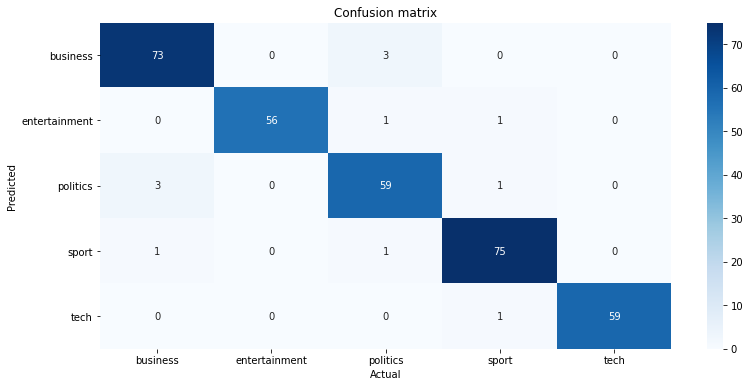

In [25]:
confusion(df, knnc_pred, labels_test)

In [27]:
with open('../../models/bbc/best_knnc.pickle', 'wb') as output:
    pickle.dump(best_knnc, output)

In [ ]:
with open('../../models/bbc/best_knnc.pickle', 'rb') as f:
    best_knnc = pickle.load(f)

In [31]:
df_sc = pd.read_csv("../../models/bbc/models_score.csv")

In [32]:
row = [
    'KNN',
    accuracy_score(labels_train, best_knnc.predict(features_train)),
    accuracy_score(labels_test, best_knnc.predict(features_test))
    ]

In [33]:
df_sc.loc[len(df_sc)] = row

In [35]:
df_sc.to_csv('../../models/bbc/models_score.csv', index=False)